In [1]:
#READING THE CSV FILE

from matplotlib import pyplot as plt
import numpy as np
import csv
import math as math
plt.rcParams['figure.figsize'] = [20, 5]


with open('daily-minimum-temperatures.csv') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',')
    temperature_set = []
    date_set = []
    for i, row in enumerate(csv_reader):        
        date = row[0]
        temp = row[1]
        if(i != 0):
            date_set.append(date)
            temperature_set.append(float(temp))

In [2]:
def split(a, n):
    k, m = divmod(len(a), n)
    return (a[i * k + min(i, m):(i + 1) * k + min(i + 1, m)] for i in range(n))

In [3]:
#SEPARATE TRAINING AND TEST SET
temperature_test_set = []
temperature_training_set = []

temperature_mean = np.mean(temperature_set)
temperature_std  = np.std (temperature_set)

temperature_max = np.max(temperature_set)
temperature_min = np.min(temperature_set)

#Setting apart test and training sets
for idx, date in enumerate(date_set):
    if date[0:4] == '1990': #Warning: it works! And doing 0:3 doesnt
        temperature_test_set.append(float(temperature_set[idx]))
    else:
        temperature_training_set.append(float(temperature_set[idx]))
        
#temperature_test_set = (temperature_test_set - temperature_mean)/temperature_std
#temperature_training_set = (temperature_training_set - temperature_mean)/temperature_std

In [4]:
#Setting hyperparameters and the coefficients for the tanh output transformation
#Split the training set using k-fold
k_fold = 10
T_max = 100
T_set = list(range(1,T_max+1)) #np.r_[1:30:1]
lambda_set = np.array([0, 10e-6, 10e-5, 10e-4, 10e-3, 10e-2, 10e-1, 10, 100, 1000, 10000])
dly = 5


#splitted_temperature_training_set = list(split(temperature_training_set, k_fold))
W_1 = []
for t_idx in T_set:
        temp = np.random.random((t_idx , dly))
        for row_idx, _ in enumerate(temp):      
            mean_temp = np.mean(temp[row_idx])
            #temp[row_idx] = (temp[row_idx] - mean_temp)
            norm_temp = np.linalg.norm(temp[row_idx])
            #temp[row_idx] = temp[row_idx]/(norm_temp)
        W_1.append(temp)

In [5]:
W_1[3]

array([[0.40800427, 0.55164147, 0.26424992, 0.10201929, 0.17468194],
       [0.98599424, 0.42711875, 0.78833835, 0.01570742, 0.01278481],
       [0.10024394, 0.38606468, 0.60102623, 0.40381713, 0.06587454],
       [0.58376329, 0.17383124, 0.64858898, 0.25962066, 0.10262352]])

In [6]:
#Setting both test and training set into a adequate format, which has 5 inputs of delayed data
training_input = []
training_output = []

test_input = []
test_output = []

for idx in range(0,len(temperature_training_set) - dly-1):
    #training_input.append((temperature_training_set[idx:idx+dly]- temperature_mean)/temperature_std)
    training_input.append((0.6*(temperature_training_set[idx:idx+dly] - temperature_min)/(temperature_max - temperature_min)-0.3))
    training_output.append(temperature_training_set[idx+dly+1])

for idx in range(0,len(temperature_test_set) - dly-1):
    test_input.append((0.6*(temperature_test_set[idx:idx+dly] - temperature_min)/(temperature_max-temperature_min) - 0.3))
    test_output.append(temperature_test_set[idx+dly+1])

In [7]:
RMSE_set = np.zeros((len(lambda_set), len(T_set)))
for W_idx, W_current_element in enumerate(W_1): #Indexing each W    
    #output of tanh function with the ones added in the left
    T1 = np.c_[np.ones(len(training_output)), np.tanh(np.transpose(np.matmul(W_current_element, np.transpose(training_input))))]
    
    splitted_training_input  = list(split(T1, k_fold))
    splitted_training_output = list(split(training_output, k_fold))
        
    #definition of our beloved I' matrix
    I_line = np.identity(np.shape(T1)[1])
    I_line[0][0] = 0
    
    for lambda_idx, lambda_current_element in enumerate(lambda_set): #calculation of the weights for a given lambda/T1        
        SE = 0
        for k_fold_idx in range(k_fold):     
            current_training_input_set = []
            current_validation_input_set = []

            current_training_output_set = []
            current_validation_output_set = []
            #Definition of the folds, given the current fold stats
            for k_fold_val_turn in range(k_fold):
                if (k_fold_val_turn != k_fold_idx):
                    current_training_input_set.append(splitted_training_input[k_fold_val_turn])
                    current_training_output_set.append(np.array(splitted_training_output[k_fold_val_turn]))
                else:
                    current_validation_input_set.append(splitted_training_input[k_fold_val_turn])
                    current_validation_output_set.append(splitted_training_output[k_fold_val_turn])
            current_training_input_set = np.vstack(current_training_input_set)
            current_training_output_set = np.concatenate(current_training_output_set)
            current_validation_input_set = np.vstack(current_validation_input_set)
            current_validation_output_set = np.concatenate(current_validation_output_set)            
            

            W_2 = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(current_training_input_set), current_training_input_set) + lambda_current_element*I_line), np.matrix.transpose(current_training_input_set)), current_training_output_set)
            for test_idx , test_element in enumerate(current_validation_input_set):
                SE = SE + (np.matmul(W_2, np.matrix.transpose(test_element)) - current_validation_output_set[test_idx])**2/((len(current_validation_output_set)*(k_fold)))   
        RMSE_set[lambda_idx, W_idx] = math.sqrt(SE)

In [8]:
print("lambda = " + str(lambda_set[np.squeeze(np.where(RMSE_set == np.amin(RMSE_set)))[0] ]  ))
print("Numero de atributos: = " + str(T_set[np.squeeze(np.where(RMSE_set == np.amin(RMSE_set)))[1] ]  ))
print("RMSE de validação = " + str(np.amin(RMSE_set)))

lambda = 0.0001
Numero de atributos: = 32
RMSE de validação = 2.917165416732858


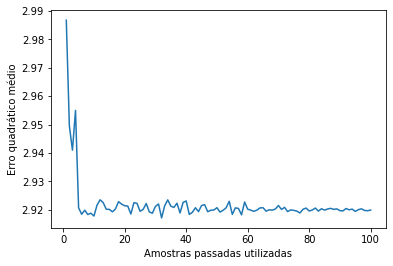

In [9]:
plt.plot(T_set, RMSE_set[np.squeeze(np.where(RMSE_set == np.amin(RMSE_set)))[0]])
plt.xlabel('Amostras passadas utilizadas')
plt.ylabel('Erro quadrático médio')
plt.show()

In [10]:
RMSE_avg_fT = np.mean(RMSE_set, axis = 0)

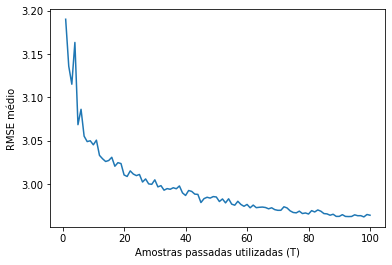

In [11]:
plt.plot(T_set, RMSE_avg_fT)
plt.xlabel('Amostras passadas utilizadas (T)')
plt.ylabel('RMSE médio')
plt.rcParams['figure.figsize'] = [20, 5]
plt.show()

In [12]:
print("Numero de atributos: = " + str(T_set[np.squeeze(np.where(RMSE_avg_fT == np.amin(RMSE_avg_fT))) ]  ))
print("RMSE = " + str(np.amin(RMSE_avg_fT)))

Numero de atributos: = 98
RMSE = 2.962051312751396


In [13]:
W_idx = 19
lambda_idx = 2

W_current_element = W_1[W_idx]
lambda_value = lambda_set[lambda_idx]   
lambda_value = 0
T1 = [] #output from the tanh function, with a 1's column added in the left
for train_idx in training_input:
    T1.append(np.tanh(np.matmul(W_current_element,np.transpose(train_idx))))
T1 = np.c_[np.ones(len(training_output)), np.matrix(T1)]

#definition of our beloved I' matrix
I_line = np.identity(np.shape(T1)[1])
I_line[0][0] = 0
    

SE = 0

W_2 = np.matmul(np.matmul(np.linalg.inv(np.matmul(np.matrix.transpose(T1),T1) + lambda_value*I_line), np.matrix.transpose(T1)), training_output)

Test_1 = np.c_[np.ones(len(test_output)), np.tanh(np.transpose(np.matmul(W_current_element, np.transpose(test_input))))]
predicted_result_set = []
for test_idx , test_element in enumerate(Test_1):
    SE = SE + (np.squeeze(np.matmul(W_2, np.matrix.transpose(test_element))) - test_output[test_idx])**2/(len(test_output))
    predicted_result_set.append(np.matmul(W_2, np.matrix.transpose(test_element)))
predicted_result_set = np.squeeze(predicted_result_set)

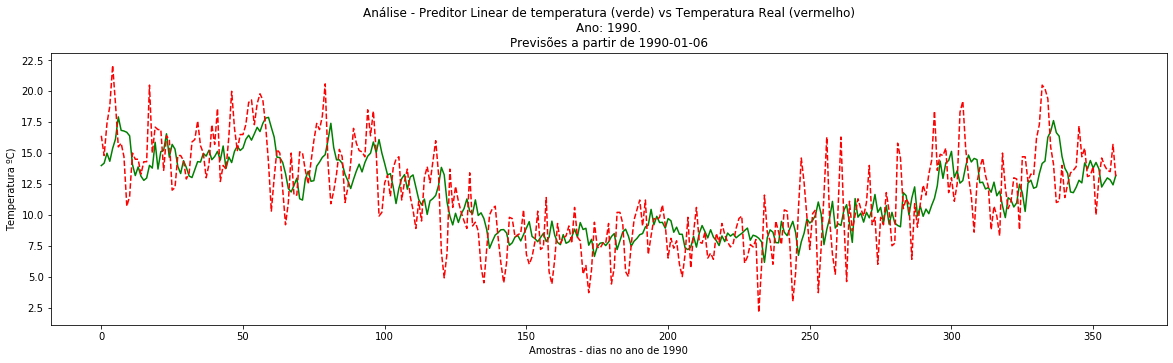

In [14]:
plt.plot(np.array(range(len(predicted_result_set))), predicted_result_set, 'g')
plt.plot(np.array(range(len(predicted_result_set))), test_output, 'r--')
plt.xlabel('Amostras - dias no ano de 1990')
plt.ylabel('Temperatura ºC)')
plt.title('Análise - Preditor Linear de temperatura (verde) vs Temperatura Real (vermelho)\nAno: 1990.\nPrevisões a partir de ' + date_set[3285 + dly])
plt.show()

In [15]:
SE

matrix([[7.71668187]])

In [16]:
lambda_set[2]

0.0001